In [131]:
import os
import numpy as np
import pandas as pd
from scipy.io import wavfile 
from hmmlearn import hmm #importing GaussianHMM 
import librosa # reading wavefiles
from librosa.feature import mfcc #to extract mfcc features
from sklearn.metrics import classification_report
import shutil
from sklearn.model_selection import train_test_split
import librosa.display
import matplotlib.pyplot as plt
import random 

## Split audio files into training and testing folders
Create subfolders by emotions and sort audio files into those folders. 

In [132]:
def split_dataset(csv_file, base_dir, train_dir, test_dir, test_size=0.2):
    """
    Split dataset into training and testing folders based on the CSV metadata.
    
    Parameters:
        csv_file (str): Path to the CSV file containing metadata.
        base_dir (str): Base directory where the audio files are located.
        train_dir (str): Output directory for training data.
        test_dir (str): Output directory for testing data.
        test_size (float): Proportion of data to use for testing.
    """
    # Load the dataset from CSV
    data = pd.read_csv(csv_file)

    # Split the data into training and testing sets
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42, stratify=data['emotion_label'])

    # Function to copy files to the appropriate folder
    def copy_files(data_subset, target_dir):
        for _, row in data_subset.iterrows():
            emotion = row['emotion_label']
            file_path = row['path']
            
            # Create the emotion folder inside the target directory
            emotion_folder = os.path.join(target_dir, emotion)
            os.makedirs(emotion_folder, exist_ok=True)
            
            # Copy the file
            try:
                shutil.copy(file_path, emotion_folder)
            except FileNotFoundError:
                print(f"File not found: {file_path}")

    # Create training and testing folders
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Copy files to their respective directories
    print("Copying training files...")
    copy_files(train_data, train_dir)
    print("Copying testing files...")
    copy_files(test_data, test_dir)

    print(f"Dataset split complete! Training data: {train_dir}, Testing data: {test_dir}")

# Example Usage
csv_file = "emodb_features.csv"  # Path to your CSV file
base_dir = "EMODB_preporcessed"  # Base directory containing the audio files
train_dir = "EMODB_train"  # Output directory for training data
test_dir = "EMODB_test"  # Output directory for testing data

split_dataset(csv_file, base_dir, train_dir, test_dir, test_size=0.2)


Copying training files...
Copying testing files...
Dataset split complete! Training data: EMODB_train, Testing data: EMODB_test


## Sort audio file by Emotion

In [133]:
# Re-load the CSV file
csv_path = 'emodb_features.csv'
data = pd.read_csv(csv_path)

# Define the new folder structure
output_base_dir = "EMODB_sorted"
os.makedirs(output_base_dir, exist_ok=True)

# Create subfolders for each emotion and move the audio files into them
for _, row in data.iterrows():
    emotion = row['emotion_label']
    file_path = row['path']

    # Create emotion folder if it doesn't exist
    emotion_folder = os.path.join(output_base_dir, emotion)
    os.makedirs(emotion_folder, exist_ok=True)

    # Move or copy the file into the emotion folder
    try:
        shutil.copy(file_path, emotion_folder)  # Use shutil.move() to move instead of copy
    except FileNotFoundError:
        print(f"File not found: {file_path}")

# Check the result
os.listdir(output_base_dir)

['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']

## HMM implementation

In [134]:
def extract_mfcc_features(file_path, sampling_rate=16000, n_mfcc=13):
    """
    Extract MFCC features from an audio file.
    :param file_path: Path to the audio file
    :param sampling_rate: Sampling rate for audio (default: 16 kHz)
    :param n_mfcc: Number of MFCCs to compute (default: 13)
    :return: MFCC features (time x features)
    """
    audio, sr = librosa.load(file_path, sr=sampling_rate)
    mfcc_features = mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfcc_features.T  # Transpose for time x features


class HMMTrainer:
    def __init__(self, n_components=4):
        """
        Initialize the GaussianHMM trainer.
        :param n_components: Number of hidden states in the HMM.
        """
        self.model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=100)

    def train(self, X):
        """
        Train the HMM using the provided feature matrix.
        :param X: Feature matrix (time x features)
        """
        self.model.fit(X)

    def get_score(self, X):
        """
        Compute the log likelihood of the HMM for the given features.
        :param X: Feature matrix (time x features)
        :return: Log likelihood score
        """
        return self.model.score(X)

def train_hmm_models(base_dir):
    """
    Train an HMM for each emotion in the dataset.
    :param base_dir: Path to the dataset directory (emotion subfolders).
    :return: A dictionary of trained HMM models.
    """
    hmm_models = {}
    for emotion in os.listdir(base_dir):
        emotion_dir = os.path.join(base_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue

        features = []
        for file_name in os.listdir(emotion_dir):
            if file_name.endswith(".wav"):
                file_path = os.path.join(emotion_dir, file_name)
                mfcc_features = extract_mfcc_features(file_path)
                features.append(mfcc_features)

        if len(features) > 0:
            X = np.vstack(features)
            trainer = HMMTrainer(n_components=4)
            trainer.train(X)
            hmm_models[emotion] = trainer
            print(f"Trained HMM for emotion: {emotion}")
        else:
            print(f"No data for emotion: {emotion}")

    return hmm_models

def predict_emotions(hmm_models, test_dir):
    """
    Predict emotions for all audio files in the test directory and calculate accuracy.
    :param hmm_models: Dictionary of trained HMM models.
    :param test_dir: Path to the test dataset (organized into emotion subfolders).
    :return: A tuple of (predictions, accuracy).
    """
    correct = 0
    total = 0
    predictions = {}

    for emotion in os.listdir(test_dir):
        emotion_folder = os.path.join(test_dir, emotion)
        if not os.path.isdir(emotion_folder):
            continue

        for file_name in os.listdir(emotion_folder):
            if file_name.endswith(".wav"):
                file_path = os.path.join(emotion_folder, file_name)
                mfcc_features = extract_mfcc_features(file_path)

                # Evaluate the file on all HMM models
                scores = {label: model.get_score(mfcc_features) for label, model in hmm_models.items()}
                predicted_emotion = max(scores, key=scores.get)
                predictions[file_name] = predicted_emotion

                # Compare with actual emotion
                if predicted_emotion == emotion:
                    correct += 1
                total += 1

    accuracy = correct / total if total > 0 else 0
    return predictions, accuracy

In [135]:
if __name__ == "__main__":
    random.seed(123)
    # Paths to the training and test datasets
    base_dir = "EMODB_train"  # Path to the organized training dataset (emotion subfolders)
    test_dir = "EMODB_test"  # Path to the organized test dataset (emotion subfolders)

    # Train HMM models
    print("Training HMM models...")
    hmm_models = train_hmm_models(base_dir)

    # Test HMM models
    print("Testing HMM models...")
    predictions, accuracy = predict_emotions(hmm_models, test_dir)

    # Print predictions and overall accuracy
    print("\nPrediction Results:")
    for file, predicted_emotion in predictions.items():
        print(f"File: {file}, Predicted Emotion: {predicted_emotion}")

    print(f"\nOverall Accuracy: {accuracy:.2%}")

Training HMM models...
Trained HMM for emotion: anger
Trained HMM for emotion: boredom
Trained HMM for emotion: disgust
Trained HMM for emotion: fear
Trained HMM for emotion: happiness
Trained HMM for emotion: neutral
Trained HMM for emotion: sadness
Testing HMM models...

Prediction Results:
File: 03a02Wb.wav, Predicted Emotion: happiness
File: 03a02Wc.wav, Predicted Emotion: anger
File: 08b01Wa.wav, Predicted Emotion: anger
File: 08b02Wd.wav, Predicted Emotion: anger
File: 08b09Wa.wav, Predicted Emotion: anger
File: 09a05Wb.wav, Predicted Emotion: anger
File: 09b09Wa.wav, Predicted Emotion: anger
File: 11a05Wd.wav, Predicted Emotion: anger
File: 11b10Wa.wav, Predicted Emotion: anger
File: 12a01Wc.wav, Predicted Emotion: anger
File: 12a04Wc.wav, Predicted Emotion: anger
File: 12b10Wa.wav, Predicted Emotion: anger
File: 13a04Wc.wav, Predicted Emotion: anger
File: 13b10Wa.wav, Predicted Emotion: anger
File: 14a02Wa.wav, Predicted Emotion: anger
File: 14a02Wc.wav, Predicted Emotion: ange

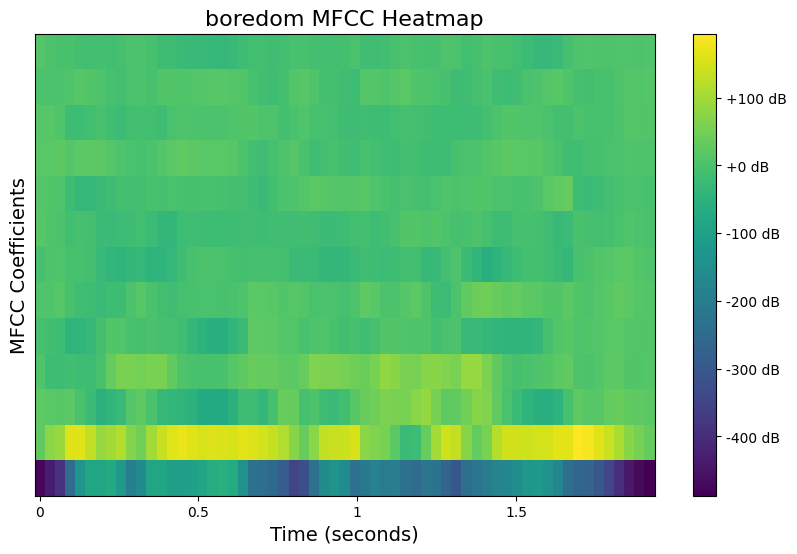

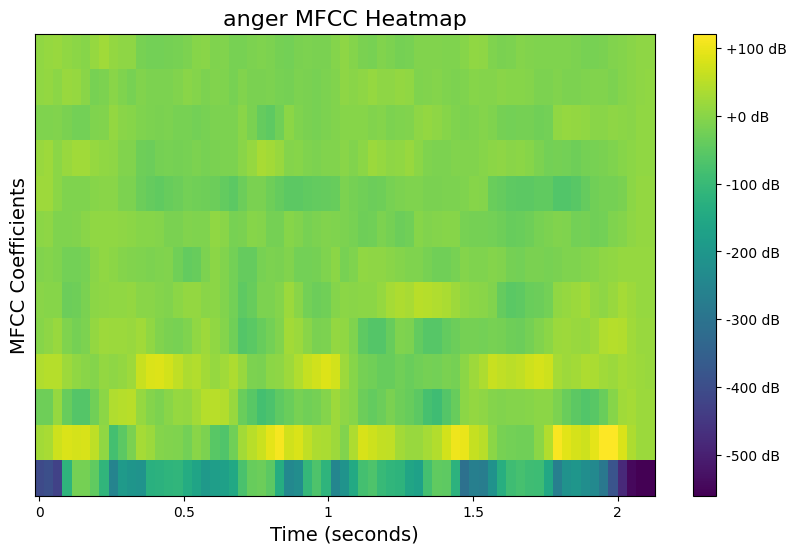

In [136]:
def plot_mfcc_heatmap(emotion, audio_file, n_mfcc=13):
    """
    Visualize MFCCs as a heatmap for an audio file.
    
    Parameters:
        audio_file (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to extract.
    """
    # Load audio
    y, sr = librosa.load(audio_file, sr=None)
    
    # Compute MFCCs
    mfccs = mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time', sr=sr, cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'{emotion} MFCC Heatmap', fontsize=16)
    plt.xlabel('Time (seconds)', fontsize=14)
    plt.ylabel('MFCC Coefficients', fontsize=14)
    plt.show()

# Example Usage
audio_file = "EMODB_test/boredom/03a04Lc.wav"
plot_mfcc_heatmap("boredom", audio_file)
audio_file = "EMODB_test/anger/03a02Wb.wav"
plot_mfcc_heatmap("anger", audio_file)

In [148]:
def plot_mfcc_time_series(emotion, audio_file, n_mfcc=13):
    """
    Visualize MFCCs as time series for an audio file.
    
    Parameters:
        audio_file (str): Path to the audio file.
        n_mfcc (int): Number of MFCC coefficients to extract.
    """
    # Load audio
    y, sr = librosa.load(audio_file, sr=None)
    
    # Compute MFCCs
    mfccs = mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    # Plot each MFCC coefficient as a time series
    plt.figure(figsize=(10, 6))
    for i in range(n_mfcc):
        plt.plot(mfccs[i], label=f'MFCC {i+1}')
    
    plt.title(f'{emotion} MFCCs as Time Series', fontsize=16)
    plt.xlabel('Time Frames', fontsize=14)
    plt.ylabel('Coefficients', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid()
    plt.savefig(f"mfcc_plot_{emotion}.jpg")
    plt.show()
    


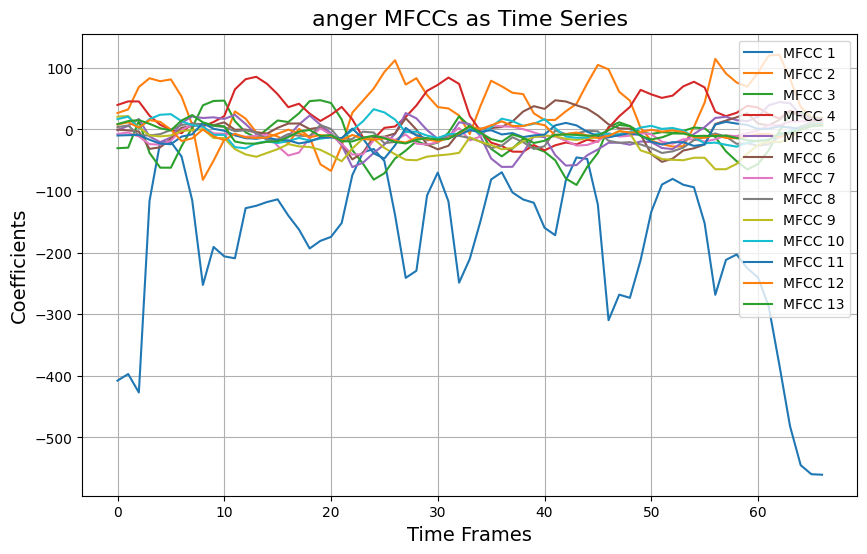

In [149]:
# Time Series anger
audio_file = "EMODB_test/anger/03a02Wb.wav"
plot_mfcc_time_series("anger", audio_file)

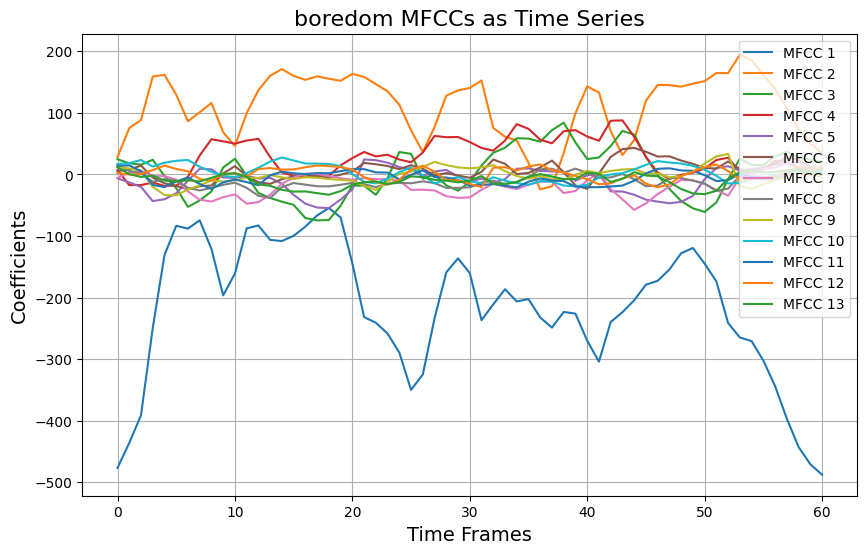

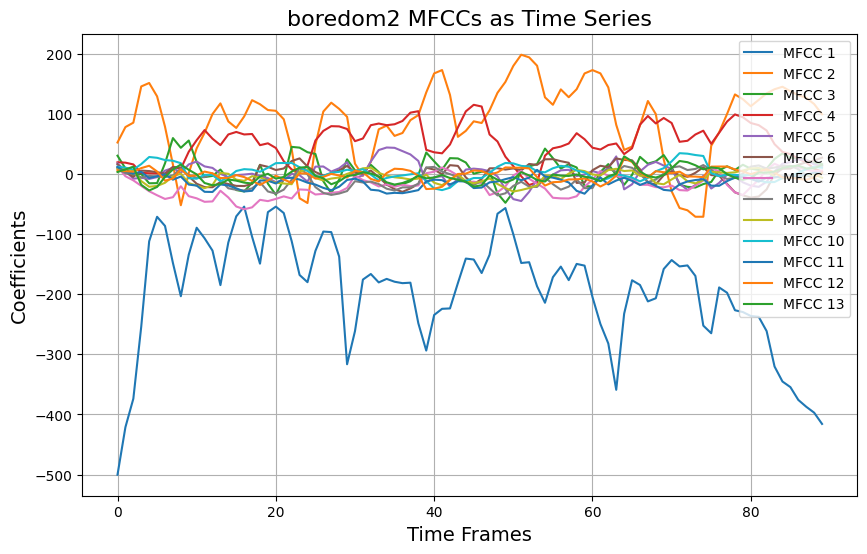

In [150]:
# Time Series boredom
audio_file = "EMODB_test/boredom/03a04Lc.wav"
plot_mfcc_time_series("boredom", audio_file)
audio_file = "EMODB_test/boredom/03b01Lb.wav"
plot_mfcc_time_series("boredom2", audio_file)

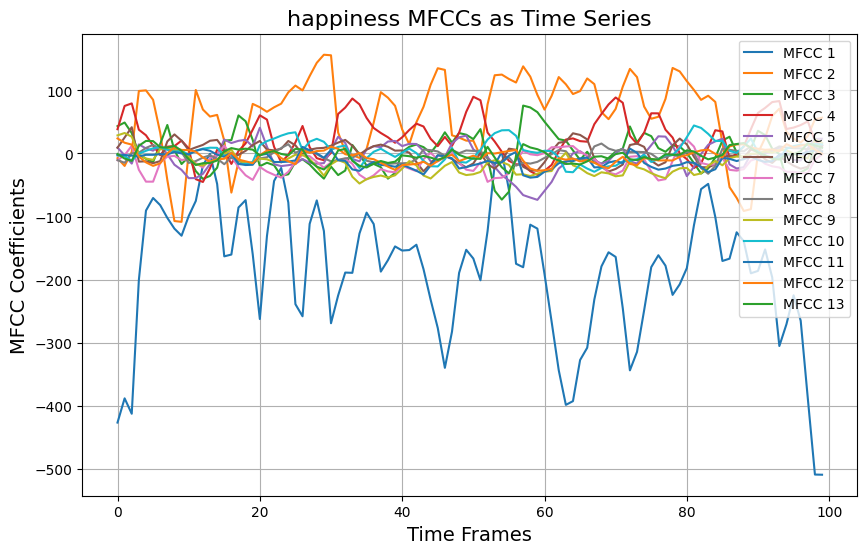

<Figure size 640x480 with 0 Axes>

In [140]:
audio_file = "EMODB_test/happiness/03a05Fc.wav"
plot_mfcc_time_series("happiness", audio_file)

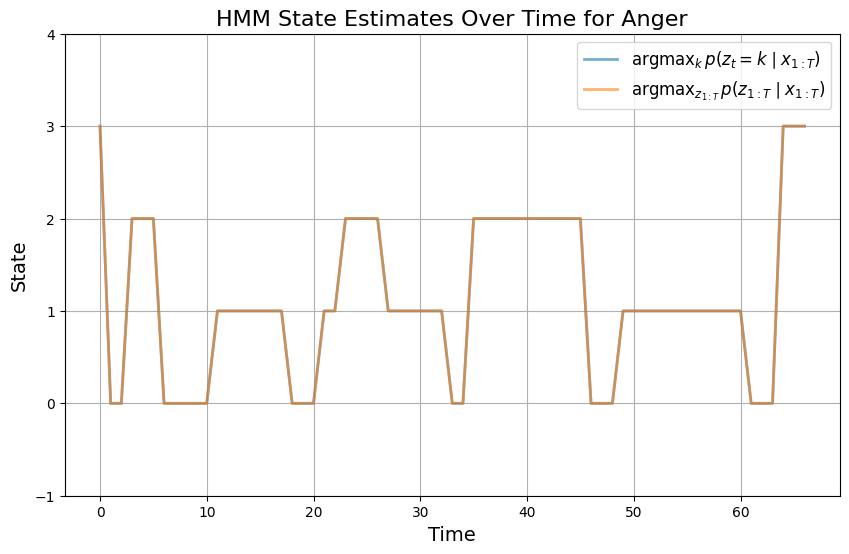

In [151]:
def plot_hmm_latent_states(model, features):
    """
    Plot latent state estimates using Forward-Backward and Viterbi algorithms.
    
    Parameters:
        model: Trained HMM model.
        features: Feature matrix for the audio file (time x features).
    """
    # Posterior probabilities (Forward-Backward)
    posteriors = model.predict_proba(features)  # Shape: (time_steps, n_states)

    # Most likely sequence (Viterbi)
    viterbi_sequence = model.predict(features)  # Shape: (time_steps,)

    # Argmax for forward-backward (most likely state at each time step)
    forward_backward_states = np.argmax(posteriors, axis=1)

    # Plotting
    time_steps = np.arange(len(features))

    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, forward_backward_states, label=r"$\mathrm{argmax}_k \, p(z_t = k \mid x_{1:T})$", alpha=0.6, linewidth=2)
    plt.plot(time_steps, viterbi_sequence, label=r"$\mathrm{argmax}_{z_{1:T}} \, p(z_{1:T} \mid x_{1:T})$", alpha=0.6, linewidth=2)

    plt.legend(fontsize=12)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("State", fontsize=14)
    plt.title("HMM State Estimates Over Time for Anger", fontsize=16)
    plt.ylim([-1, model.n_components])
    plt.grid()
    plt.savefig(f"HMM_State.jpg")
    plt.show()


# Example feature extraction for a single audio file
file_path = "EMODB_test/anger/03a02Wb.wav"
features = extract_mfcc_features(file_path)

# Assume we already have a trained HMM for this emotion
trained_hmm_model = hmm_models["anger"].model  # Replace "anger" with the appropriate emotion

# Generate the plot
plot_hmm_latent_states(trained_hmm_model, features)
